In [17]:
### data processing imports
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from scipy.stats import iqr
from AFL.automation.APIServer.Client import Client
import xarray as xr
import seaborn as sns
from os.path import basename
import pathlib
base_path = pathlib.Path('./')
### Imports for Similarity Metrics
from AFL.agent import xarray_extensions
from AFL.agent import reduce_usaxs

from AFL.agent.AgentClient import AgentClient
from AFL.agent import Metric,PhaseLabeler,AcquisitionFunction,GaussianProcess,HscedGaussianProcess

from scipy.spatial.distance import pdist

import gpflow

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Series #1 10 mg/ml P188

This data series varied the amount of phenol and benzyl alcohol from 0-15 mg/ml when it could be made. The mass balance could not make 5 of 36 samples

Text(0.5, 1.0, 'Grid Search for Turbidity\nslightly WRONG INDEXING!!!')

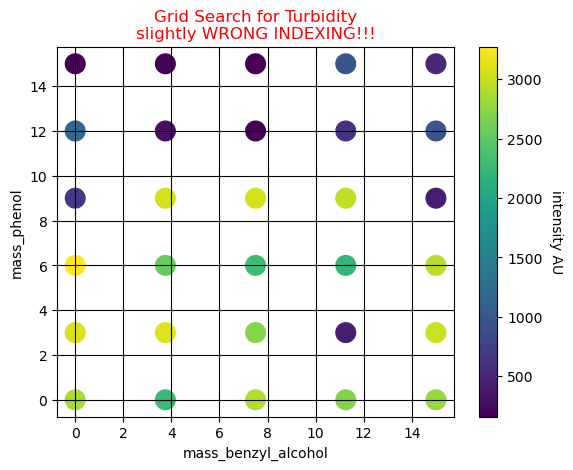

In [19]:
ds_list = []
fnames = []
comps = []
ds_all = xr.Dataset()
for fname in sorted(base_path.glob('230411_P188_Autoprepared_Series/*h5')):

    with h5py.File(fname,'r') as h5:
        key = list(h5.keys())[0]
        data = h5[key][()][:,:,1:]
        ds_static_list = []
        timed_sample = []
        fnames.append(basename(fname))
        concentrations = np.array(basename(fname).split("_")[1].split('-'),dtype='float')
        comps.append(concentrations)
        for point in data:
            timed_sample.append(point[1])
            
#             da = xr.DataArray(point[1],dims=['wavelength'],coords={'wavelength':point[0]},name='raw')
#             da.attrs['units'] = 'AU'
#             da.wavelength.attrs['units'] = 'nm'
            
#             ds_static_list.append(da)
#             # ds1_comp_list.append(da1)
            # ds2_comp_list.append(da2)
            # ds3_comp_list.append(da3)
        
        λ = point[0]
        timed_sample = np.array(timed_sample)
        da = xr.DataArray(timed_sample, dims=['time','wavelength'],
                                              coords={'time':np.linspace(0,0.1*len(timed_sample),len(timed_sample)),
                                                     'wavelength':λ},  name='raw')
        da.attrs['units'] = 'AU'
        da.wavelength.attrs['units'] = 'nm'
        da.time.attrs['units'] = 's'
        
        
        

        
        ds = xr.Dataset()
        # ds['raw'] = xr.concat(ds_static_list,dim='point')
        ds['raw'] = da
        
        maxima  = ds['raw'].max(axis=1)
        max_IQR = iqr(maxima)
        median  = np.median(maxima)
        filt_criteria = [(maxima >= median-max_IQR) & (maxima <= median+max_IQR)]
        ds['filtered_data_iqr']  = ds['raw'].where((maxima >= median-max_IQR) & (maxima <= median+max_IQR))
        
        μ_ts = maxima.mean()
        σ_ts = maxima.std()
        ds['mean_of_maxima']  = μ_ts
        ds['std_of_maxima'] = σ_ts
        ds['filtered_data_1std'] = ds['raw'].where((maxima >= μ_ts-σ_ts) & (maxima <= μ_ts+σ_ts))
        ds['maxima'] = maxima
        ds['IQR'] = ('sample',[max_IQR])
        ds['median'] = ('sample',[median])
        
        ds['fname'] = ('sample',[basename(fname)])
        ds['mass_P188'] = ('sample',[concentrations[0]])
        ds['mass_benzyl_alcohol'] = ('sample',[concentrations[1]])
        ds['mass_phenol'] = ('sample',[concentrations[2]])
        
        # ds['solutes'] = ('sample',['P188', 'benzyl_alcohol_solute','phenol_solute'])
        ds_list.append(ds)
        # μ_measurements.append(ds['intensity'].mean(axis=0).values)
        # σ_measurements.append(ds['intensity'].std(axis=0).values)
        
#         fig,axes = plt.subplots(1,2,figsize=(12,4))
#         plt.sca(axes[0])
#         ds.intensity.plot.line(x='wavelength',add_legend=False)
#         plt.gca().set(title=fname.parts[-1])
        
#         plt.sca(axes[1])
#         ds.intensity.plot(x='wavelength')#,vmin=95, vmax=2000)
comps = np.array(comps)
ds_all = xr.concat(ds_list,dim='sample')
sm = ds_all[['mass_P188', 'mass_benzyl_alcohol','mass_phenol']].to_array('solutes').transpose('sample',...)
ds_all['solute_masses'] = sm

# norm = mcolors.LogNorm(vmin=100, vmax=ds_all['median'].max())
sc  = ds_all.afl.comp.plot_scatter(['mass_benzyl_alcohol','mass_phenol'],labels='mean_of_maxima',discrete_labels=False, s=200);#,norm=norm);

cbar = plt.colorbar(sc)
cbar.set_label(label='intensity AU',rotation=270,labelpad=15)
plt.title('Grid Search for Turbidity\nslightly WRONG INDEXING!!!',color='r')

In [20]:
# ## Grid extraction
# # ds['intensity_IQR']
# fig,ax = plt.subplots(1,2,figsize=(12,4))
# for i in ds['raw']:
#     ax[0].plot(λ,i,c='r',alpha=0.1)
# ax[0].plot(λ,ds['raw'].mean(axis=0),c='k',linestyle='--')
# ax[0].set(
#     xlabel = 'wavelength in nm',
#     ylabel = 'intensity AU',
#     # yscale = 'symlog'
# )
# for i in ds['filtered_data_iqr']:
#     ax[1].plot(λ,i,c='grey',alpha=0.1)
# ax[1].plot(λ,ds['IQR'].mean(axis=0),c='mediumseagreen',linestyle='--')
# ax[1].set(
#     xlabel = 'wavelength in nm',
#     ylabel = 'intensity AU',
#     # yscale = 'symlog'
# )

# fig,ax = plt.subplots()
# ax.boxplot(maxima)
# ax.scatter(x=np.ones(len(maxima)),y=maxima)
# ax.set(
#     xlabel='some acquisition',
#     ylabel='maximum intensity',
#     title='IQR for maxima in spectra'
# )

Text(0.5, 1.0, 'Grid Search for Turbidity\n WRONG INDEXING!!!')

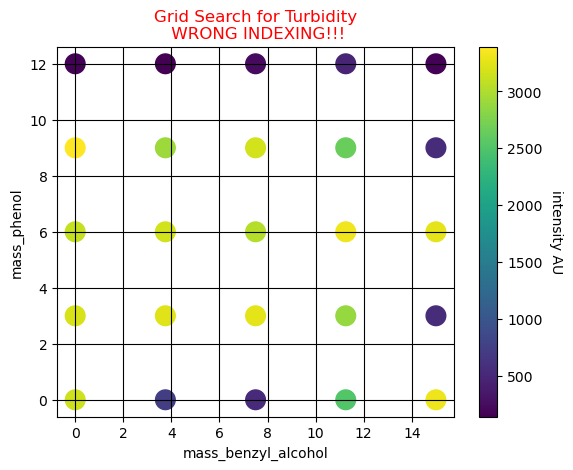

In [21]:
ds_list = []
fnames = []
comps = []
ds_all = xr.Dataset()
for fname in sorted(base_path.glob('230414_P188_Autoprepared_series/*h5')):
    with h5py.File(fname,'r') as h5:
        key = list(h5.keys())[0]
        data = h5[key][()][:,:,1:]
        ds_static_list = []
        timed_sample = []
        fnames.append(basename(fname))
        concentrations = np.array(basename(fname).split("_")[1].split('-'),dtype='float')
        comps.append(concentrations)
        for point in data:
            timed_sample.append(point[1])
            
#             da = xr.DataArray(point[1],dims=['wavelength'],coords={'wavelength':point[0]},name='raw')
#             da.attrs['units'] = 'AU'
#             da.wavelength.attrs['units'] = 'nm'
            
#             ds_static_list.append(da)
#             # ds1_comp_list.append(da1)
            # ds2_comp_list.append(da2)
            # ds3_comp_list.append(da3)
        
        λ = point[0]
        timed_sample = np.array(timed_sample)
        da = xr.DataArray(timed_sample, dims=['time','wavelength'],
                                              coords={'time':np.linspace(0,0.1*len(timed_sample),len(timed_sample)),
                                                     'wavelength':λ},  name='raw')
        da.attrs['units'] = 'AU'
        da.wavelength.attrs['units'] = 'nm'
        da.time.attrs['units'] = 's'
        
        
        

        
        ds = xr.Dataset()
        # ds['raw'] = xr.concat(ds_static_list,dim='point')
        ds['raw'] = da
        
        maxima  = ds['raw'].max(axis=1)
        max_IQR = iqr(maxima)
        median  = np.median(maxima)
        filt_criteria = [(maxima >= median-max_IQR) & (maxima <= median+max_IQR)]
        ds['filtered_data_iqr']  = ds['raw'].where((maxima >= median-max_IQR) & (maxima <= median+max_IQR))
        
        μ_ts = maxima.mean()
        σ_ts = maxima.std()
        ds['mean_of_maxima']  = μ_ts
        ds['std_of_maxima'] = σ_ts
        ds['filtered_data_1std'] = ds['raw'].where((maxima >= μ_ts-σ_ts) & (maxima <= μ_ts+σ_ts))
        ds['maxima'] = maxima
        ds['IQR'] = ('sample',[max_IQR])
        ds['median'] = ('sample',[median])
        
        ds['fname'] = ('sample',[basename(fname)])
        ds['mass_P188'] = ('sample',[concentrations[0]])
        ds['mass_benzyl_alcohol'] = ('sample',[concentrations[1]])
        ds['mass_phenol'] = ('sample',[concentrations[2]])
        
        # ds['solutes'] = ('sample',['P188', 'benzyl_alcohol_solute','phenol_solute'])
        ds_list.append(ds)
        # μ_measurements.append(ds['intensity'].mean(axis=0).values)
        # σ_measurements.append(ds['intensity'].std(axis=0).values)
        
#         fig,axes = plt.subplots(1,2,figsize=(12,4))
#         plt.sca(axes[0])
#         ds.intensity.plot.line(x='wavelength',add_legend=False)
#         plt.gca().set(title=fname.parts[-1])
        
#         plt.sca(axes[1])
#         ds.intensity.plot(x='wavelength')#,vmin=95, vmax=2000)
comps = np.array(comps)
ds_all = xr.concat(ds_list,dim='sample')
sm = ds_all[['mass_P188', 'mass_benzyl_alcohol','mass_phenol']].to_array('solutes').transpose('sample',...)
ds_all['solute_masses'] = sm


# norm = mcolors.LogNorm(vmin=100, vmax=ds_all['median'].max())
sc  = ds_all.afl.comp.plot_scatter(['mass_benzyl_alcohol','mass_phenol'],labels='mean_of_maxima',discrete_labels=False, s=200);#,norm=norm);

cbar = plt.colorbar(sc)
cbar.set_label(label='intensity AU',rotation=270,labelpad=15)
plt.title('Grid Search for Turbidity\n WRONG INDEXING!!!',color='red')

0 P188-Bz-Ph_10-0.0-0.0_mgml.h5
1 P188-Bz-Ph_10-0.0-12.0_mgml.h5
2 P188-Bz-Ph_10-0.0-15.0_mgml.h5
3 P188-Bz-Ph_10-0.0-3.0_mgml.h5
4 P188-Bz-Ph_10-0.0-6.0_mgml.h5
5 P188-Bz-Ph_10-0.0-9.0_mgml.h5
6 P188-Bz-Ph_10-11.25-0.0_mgml.h5
7 P188-Bz-Ph_10-11.25-12.0_mgml.h5
8 P188-Bz-Ph_10-11.25-15.0_mgml.h5
9 P188-Bz-Ph_10-11.25-3.0_mgml.h5
10 P188-Bz-Ph_10-11.25-6.0_mgml.h5
11 P188-Bz-Ph_10-11.25-9.0_mgml.h5
12 P188-Bz-Ph_10-15.0-0.0_mgml.h5
13 P188-Bz-Ph_10-15.0-12.0_mgml.h5
14 P188-Bz-Ph_10-15.0-15.0_mgml.h5
15 P188-Bz-Ph_10-15.0-3.0_mgml.h5
16 P188-Bz-Ph_10-15.0-6.0_mgml.h5
17 P188-Bz-Ph_10-15.0-9.0_mgml.h5
18 P188-Bz-Ph_10-3.75-0.0_mgml.h5
19 P188-Bz-Ph_10-3.75-12.0_mgml.h5
20 P188-Bz-Ph_10-3.75-15.0_mgml.h5
21 P188-Bz-Ph_10-3.75-3.0_mgml.h5
22 P188-Bz-Ph_10-3.75-6.0_mgml.h5
23 P188-Bz-Ph_10-3.75-9.0_mgml.h5
24 P188-Bz-Ph_10-7.5-0.0_mgml.h5
25 P188-Bz-Ph_10-7.5-12.0_mgml.h5
26 P188-Bz-Ph_10-7.5-15.0_mgml.h5
27 P188-Bz-Ph_10-7.5-3.0_mgml.h5
28 P188-Bz-Ph_10-7.5-6.0_mgml.h5
29 P188-Bz-Ph_10-7.

  0%|          | 0/22801 [00:00<?, ?it/s]

AxisError: axis 1 is out of bounds for array of dimension 1

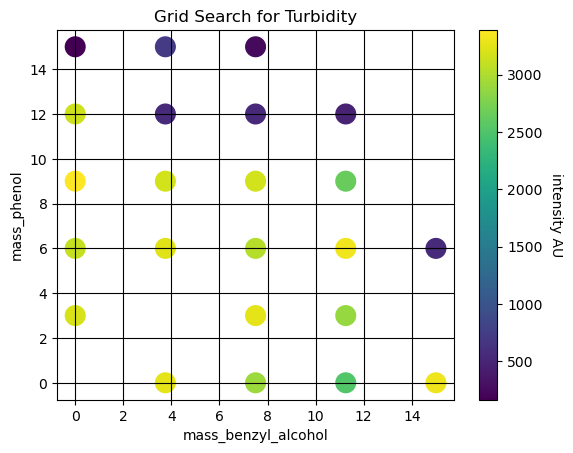

In [22]:
import os
#correct labeling
ph = np.linspace(0,15,6)
ba = np.linspace(0,15,5)
ba,ph = np.meshgrid(ba,ph)
ba,ph = ba.ravel(),ph.ravel()

original_labeling_grid = []
for i in range(len(ba)):
    original_labeling_grid.append(f'P188-Bz-Ph_10-{np.round(ba[i],2)}-{np.round(ph[i],2)}_mgml.h5')
original_labeling_grid = sorted(original_labeling_grid)
samples_made = np.copy(original_labeling_grid).tolist()
for idx, i in enumerate(samples_made):
    print(idx,i)
# for i in [29,28,24,19,0]:
for i in [17,14,13,8,0]:
    del samples_made[i]
# for idx, i in enumerate(samples_made):
#     print(idx,i)
ds_list = []
fnames = []
comps = []
ds_all_1 = xr.Dataset()
for idx, fname in enumerate(sorted(base_path.glob('230414_P188_Autoprepared_series/*h5'))):
    
#     if os.path.basename(fname) == 'P188-Bz-Ph_10-3.75-3.0_mgml.h5':
#         print('bad data')
#     else:
#         print('good data')
#         print(fname)
    with h5py.File(fname,'r') as h5:
        key = list(h5.keys())[0]
        data = h5[key][()][:,:,1:]
        ds_static_list = []
        timed_sample = []
        # fnames.append(basename(fname))
        # concentrations = np.array(basename(fname).split("_")[1].split('-'),dtype='float')
        fnames.append(samples_made[idx])
        concentrations = np.array(samples_made[idx].split("_")[1].split('-'),dtype='float')
        if samples_made[idx] in ['P188-Bz-Ph_10-3.75-3.0_mgml.h5', 'P188-Bz-Ph_10-15.0-3.0_mgml.h5']:
            pass
        else:
            comps.append(concentrations)
            for point in data:
                timed_sample.append(point[1])

            λ = point[0]
            timed_sample = np.array(timed_sample)
            da = xr.DataArray(timed_sample, dims=['time','wavelength'],
                                                  coords={'time':np.linspace(0,0.1*len(timed_sample),len(timed_sample)),
                                                         'wavelength':λ},  name='raw')
            da.attrs['units'] = 'AU'
            da.wavelength.attrs['units'] = 'nm'
            da.time.attrs['units'] = 's'

            ds = xr.Dataset()
            ds['raw'] = da

            maxima  = ds['raw'].max(axis=1)
            max_IQR = iqr(maxima)
            median  = np.median(maxima)
            filt_criteria = [(maxima >= median-max_IQR) & (maxima <= median+max_IQR)]
            ds['filtered_data_iqr']  = ds['raw'].where((maxima >= median-max_IQR) & (maxima <= median+max_IQR))

            μ_ts = maxima.mean()
            σ_ts = maxima.std()
            ds['mean_of_maxima']  = μ_ts
            ds['std_of_maxima'] = σ_ts
            ds['filtered_data_1std'] = ds['raw'].where((maxima >= μ_ts-σ_ts) & (maxima <= μ_ts+σ_ts))
            ds['maxima'] = maxima
            ds['IQR'] = ('sample',[max_IQR])
            ds['median'] = ('sample',[median])

            ds['fname'] = ('sample',[basename(fname)])
            ds['mass_P188'] = ('sample',[concentrations[0]])
            ds['mass_benzyl_alcohol'] = ('sample',[concentrations[1]])
            ds['mass_phenol'] = ('sample',[concentrations[2]])

            ds_list.append(ds)
        
comps = np.array(comps)
ds_all_1 = xr.concat(ds_list,dim='sample')
sm = ds_all_1[['mass_P188', 'mass_benzyl_alcohol','mass_phenol']].to_array('solutes').transpose('sample',...)
ds_all_1['solute_masses'] = sm


# norm = mcolors.LogNorm(vmin=100, vmax=ds_all_1['median'].max())
sc  = ds_all_1.afl.comp.plot_scatter(['mass_benzyl_alcohol','mass_phenol'],labels='mean_of_maxima',discrete_labels=False, s=200);#,norm=norm);

cbar = plt.colorbar(sc)
cbar.set_label(label='intensity AU',rotation=270,labelpad=15)
plt.title('Grid Search for Turbidity')
# plt.savefig('230414_Turbidity_DataSeries.png',dpi=300)

ds_all_1.attrs['components'] = ['mass_benzyl_alcohol','mass_phenol']
ds_all_1.attrs['AL_data'] = 'mean_of_maxima'
ds_all_1.attrs['input_uncert'] = 'std_of_maxima'
ds_all_1.attrs['mass_benzyl_alcohol_range'] = (0,15)
ds_all_1.attrs['mass_phenol_range'] = (0,15)

ds_all_1 = ds_all_1.afl.comp.add_grid(pts_per_row=151,overwrite=True)
# try:
#     ds_merged = ds_merged.afl.comp.add_grid()
# except:
#     pass
kernel = gpflow.kernels.Matern52(variance=0.5,lengthscales=2.0) + gpflow.kernels.White(1e-1)

GPR = HscedGaussianProcess.GPR(
    dataset = ds_all_1,
    kernel=kernel
)
GPR.optimize(15,progress_bar=True)

result = GPR.predict(ds_all_1.attrs['components_grid'])
ds_all_1['GP_mean'] = ('grid',result['mean'].squeeze())
ds_all_1['GP_var'] = ('grid',result['var'].squeeze())
ds_all_1.afl.comp.plot_surface(ds_all_1.attrs['components_grid'],labels='GP_mean')
ds_all_1.afl.comp.plot_surface(ds_all_1.attrs['components_grid'],labels='GP_var')

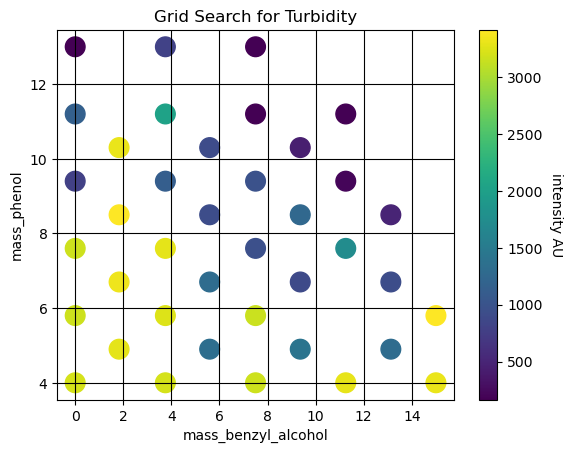

In [23]:
ds_list = []
fnames = []
comps = []
ds_all_2 = xr.Dataset()
for fname in sorted(base_path.glob('230417_P188_Autoprepared_Series/*h5')):
    if os.path.basename(fname) == 'P188-Bz-Ph_10-11.25-5.8_mgml.h5':
        pass
    else:
    # print(fname)
        with h5py.File(fname,'r') as h5:
            key = list(h5.keys())[0]
            data = h5[key][()][:,:,1:]
            ds_static_list = []
            timed_sample = []
            fnames.append(basename(fname))
            concentrations = np.array(basename(fname).split("_")[1].split('-'),dtype='float')
            comps.append(concentrations)
            for point in data:
                timed_sample.append(point[1])

            λ = point[0]
            timed_sample = np.array(timed_sample)
            da = xr.DataArray(timed_sample, dims=['time','wavelength'],
                                                  coords={'time':np.linspace(0,0.1*len(timed_sample),len(timed_sample)),
                                                         'wavelength':λ},  name='raw')
            da.attrs['units'] = 'AU'
            da.wavelength.attrs['units'] = 'nm'
            da.time.attrs['units'] = 's'





            ds = xr.Dataset()
            # ds['raw'] = xr.concat(ds_static_list,dim='point')
            ds['raw'] = da

            maxima  = ds['raw'].max(axis=1)
            max_IQR = iqr(maxima)
            median  = np.median(maxima)
            filt_criteria = [(maxima >= median-max_IQR) & (maxima <= median+max_IQR)]
            ds['filtered_data_iqr']  = ds['raw'].where((maxima >= median-max_IQR) & (maxima <= median+max_IQR))

            μ_ts = maxima.mean()
            σ_ts = maxima.std()
            ds['mean_of_maxima']  = μ_ts
            ds['std_of_maxima'] = σ_ts
            ds['filtered_data_1std'] = ds['raw'].where((maxima >= μ_ts-σ_ts) & (maxima <= μ_ts+σ_ts))
            ds['maxima'] = maxima
            ds['IQR'] = ('sample',[max_IQR])
            ds['median'] = ('sample',[median])

            ds['fname'] = ('sample',[basename(fname)])
            ds['mass_P188'] = ('sample',[concentrations[0]])
            ds['mass_benzyl_alcohol'] = ('sample',[concentrations[1]])
            ds['mass_phenol'] = ('sample',[concentrations[2]])

            ds_list.append(ds)
        
comps = np.array(comps)
ds_all_2 = xr.concat(ds_list,dim='sample')
sm = ds_all_2[['mass_P188', 'mass_benzyl_alcohol','mass_phenol']].to_array('solutes').transpose('sample',...)
ds_all_2['solute_masses'] = sm


# norm = mcolors.LogNorm(vmin=100, vmax=ds_all_2['median'].max())
sc  = ds_all_2.afl.comp.plot_scatter(['mass_benzyl_alcohol','mass_phenol'],labels='mean_of_maxima',discrete_labels=False, s=200);#,norm=norm);

cbar = plt.colorbar(sc)
cbar.set_label(label='intensity AU',rotation=270,labelpad=15)
plt.title('Grid Search for Turbidity')
plt.savefig('230417_finer_condition_mesh.png',dpi=300)

--> Making grid for components ['mass_benzyl_alcohol', 'mass_phenol'] at 151 pts_per_row
{'mass_benzyl_alcohol': {'min': 0, 'max': 15, 'steps': 151}, 'mass_phenol': {'min': 0, 'max': 15, 'steps': 151}}


  0%|          | 0/22801 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 14.82it/s]


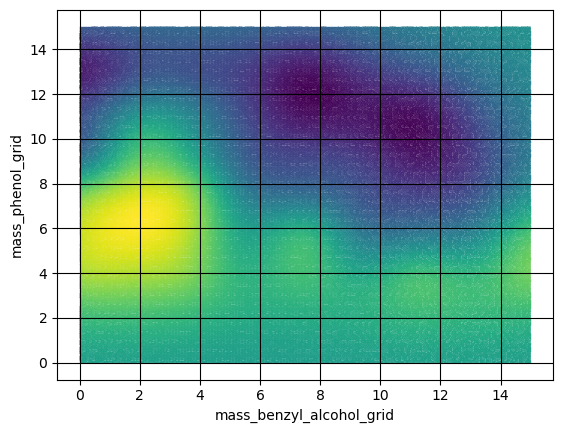

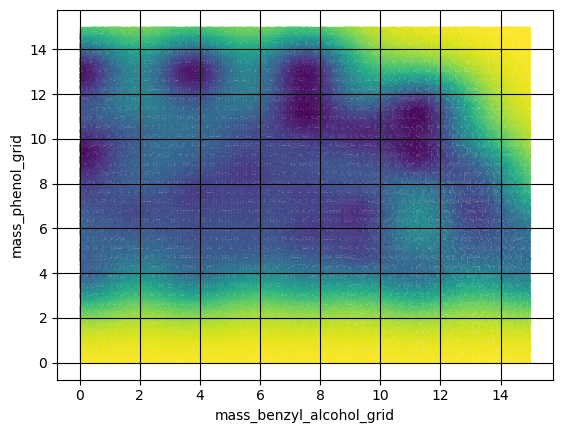

In [25]:
ds_all_2.attrs['components'] = ['mass_benzyl_alcohol','mass_phenol']
ds_all_2.attrs['AL_data'] = 'mean_of_maxima'
ds_all_2.attrs['input_uncert'] = 'std_of_maxima'
ds_all_2.attrs['mass_benzyl_alcohol_range'] = (0,15)
ds_all_2.attrs['mass_phenol_range'] = (0,15)

ds_all_2 = ds_all_2.afl.comp.add_grid(pts_per_row=151,overwrite=True)
# try:
#     ds_merged = ds_merged.afl.comp.add_grid()
# except:
#     pass
kernel = gpflow.kernels.Matern52(variance=0.5,lengthscales=2.0) + gpflow.kernels.White(1e-1)

GPR = HscedGaussianProcess.GPR(
    dataset = ds_all_2,
    inputs = ds_all_2['median'],
    uncertainties=ds_all_2['IQR'],
    kernel=kernel
)
GPR.optimize(15,progress_bar=True)

result = GPR.predict(ds_all_2.attrs['components_grid'])
ds_all_2['GP_mean'] = ('grid',result['mean'].squeeze())
ds_all_2['GP_var'] = ('grid',result['var'].squeeze())
ds_all_2.afl.comp.plot_surface(ds_all_2.attrs['components_grid'],labels='GP_mean')
ds_all_2.afl.comp.plot_surface(ds_all_2.attrs['components_grid'],labels='GP_var')

## Merged Data from 04/11-04/17

<Figure size 640x480 with 0 Axes>

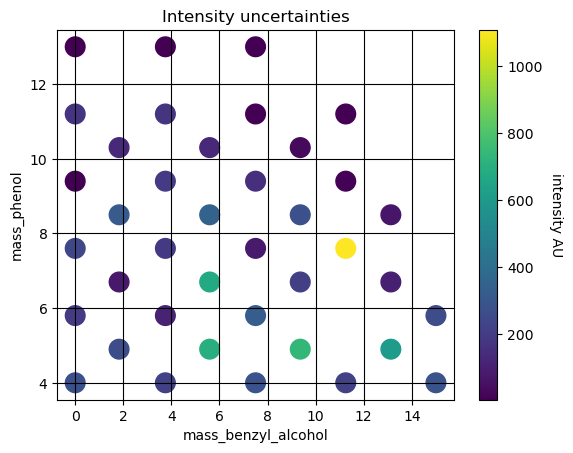

In [26]:
plt.figure()
sc  = ds_all_2.afl.comp.plot_scatter(['mass_benzyl_alcohol','mass_phenol'],labels='std_of_maxima',discrete_labels=False, s=200);#,norm=norm);

cbar = plt.colorbar(sc)
cbar.set_label(label='intensity AU',rotation=270,labelpad=15)
plt.title('Intensity uncertainties')
plt.savefig('230417_measurement_uncertainties.png',dpi=300)

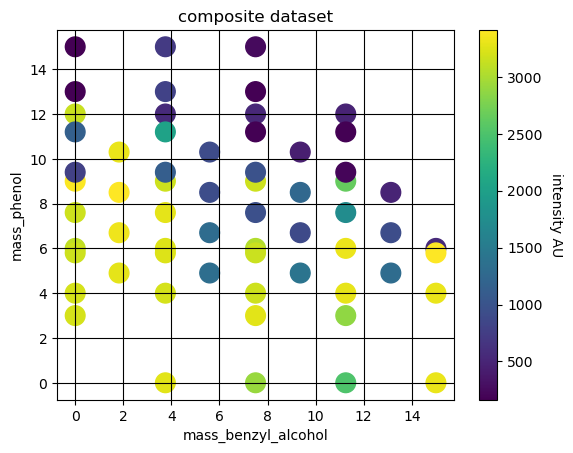

In [29]:
ds_merged = xr.concat([ds_all_1,ds_all_2],dim='sample');
sc  = ds_merged.afl.comp.plot_scatter(['mass_benzyl_alcohol','mass_phenol'],labels='mean_of_maxima',discrete_labels=False, s=200);#,norm=norm);
cbar = plt.colorbar(sc)
cbar.set_label(label='intensity AU',rotation=270,labelpad=15)
ax = plt.gca()
ax.set(
    title = 'composite dataset'
)
plt.savefig('230411-230417_composite_dataset.png',dpi=300)

[Text(0.5, 0, 'mass benzyl alcohol mg/ml'),
 Text(0.5, 0.5, 'mass phenol mg/ml'),
 Text(0.5, 0, 'μ intensity'),
 Text(0.5, 0.92, 'P188 at 10 mg/ml')]

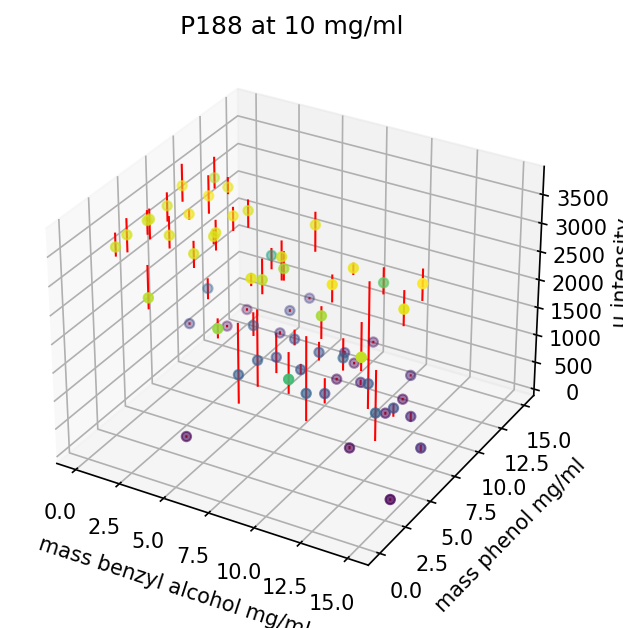

In [10]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(projection='3d')
ax.scatter3D(ds_merged['mass_benzyl_alcohol'],ds_merged['mass_phenol'],ds_merged['median'],c=ds_merged['median'],label='raw data')
for i in range(len(ds_merged['mass_benzyl_alcohol'])):
    x  = ds_merged['mass_benzyl_alcohol'][i]
    y  = ds_merged['mass_phenol'][i]
    # dz = ds_merged['IQR'][i]
    # z  = ds_merged['median'][i]
    dz = ds_merged['std_of_maxima'][i]
    z  = ds_merged['mean_of_maxima'][i]
    z1 = z-dz
    z2 = z+dz
    ax.plot3D(xs=[x,x], ys=[y,y], zs=[z1,z2],c='r',linewidth=1)
    
ax.set(
    xlabel='mass benzyl alcohol mg/ml',
    ylabel='mass phenol mg/ml',
    zlabel='μ intensity',
    title ='P188 at 10 mg/ml' 
)
# fig.savefig('μ and σ plot.png')

### Standard GP regression with RBF and white noise kernels

This is showing some convergence but is not really experimentally valid. We should be able to incorporate the experimental uncertainties more intelligently

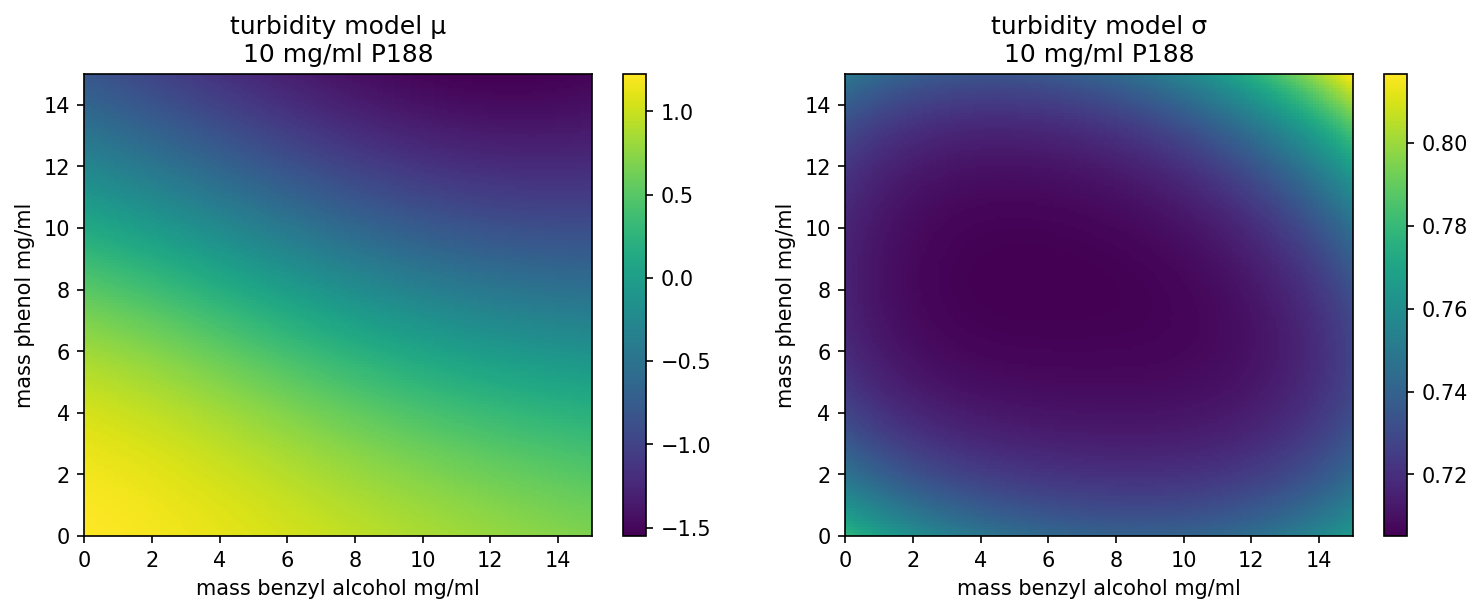

In [30]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, RationalQuadratic, Matern, ConstantKernel as C
from sklearn.cluster import KMeans

X0 = np.array([ds_merged['mass_benzyl_alcohol'],ds_merged['mass_phenol']]).T
X1 = np.copy(X0)
X1[:,0] = (X1[:,0] - X1[:,0].mean())/X1[:,0].std()
X1[:,1] = (X1[:,1] - X1[:,1].mean())/X1[:,1].std()

y1 = np.expand_dims(ds_merged['mean_of_maxima'],axis=1).copy()
σ = np.expand_dims(ds_merged['std_of_maxima'],axis=1).copy()

y1 = (y1 - y1.mean())/y1.std()
ϵ = (σ - σ.mean())/σ.std()


#the length scale here drops and the result is poor
kernel = Matern(length_scale=(4.0,4.0),nu=2.5, length_scale_bounds='fixed') + WhiteKernel(noise_level=1, noise_level_bounds=(1e-5,1e3))# ,length_scale_bounds=[(1e-1,1e2),(1e-1,1e2)]
gpr = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=1000,normalize_y=True).fit(X1,y1);
gpr.score(X0,y1), gpr.kernel_

# #works with no errors, noise level drops to acceptable levels
# kernel = 1.0 * RBF(length_scale=(0.5,0.5),length_scale_bounds=[(1e-1,1e1),(1e-1,1e1)]) + WhiteKernel(noise_level=100, noise_level_bounds=(1e-1,1e3))
# gpr = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=1000).fit(X1,y1);
# print(gpr.score(X1,y1), gpr.kernel_)

# #plotting
# # in normalized GP space where μ = 0.0 and a value of 1.0 is one std dev
# mass_ba = np.linspace(X0.min(0)[0],X0.max(0)[0],151)
# mass_ph = np.linspace(X0.min(0)[1],X0.max(0)[1],151)

# in normalized GP space where μ = 0.0 and a value of 1.0 is one std dev
mass_ba = np.linspace(X1.min(0)[0],X1.max(0)[0],151)
mass_ph = np.linspace(X1.min(0)[1],X1.max(0)[1],151)

mba, mph = np.meshgrid(mass_ba,mass_ph)
X_eval = np.stack((mba.ravel(), mph.ravel()),axis=1)

μ_posterior, σ_posterior = gpr.predict(X_eval, return_std=True)
fig,ax = plt.subplots(1,2,dpi=150,figsize=(12,4))
imsh1 = ax[0].imshow(μ_posterior.reshape(151,151),origin='lower', extent=[0, 15, 0, 15], aspect='auto')
imsh2 = ax[1].imshow(σ_posterior.reshape(151,151),origin='lower', extent=[0, 15, 0, 15], aspect='auto')
ax[0].set(
    xlabel='mass benzyl alcohol mg/ml',
    ylabel='mass phenol mg/ml',
    title ='turbidity model μ\n10 mg/ml P188',
)
plt.colorbar(imsh1,ax=ax[0])
ax[1].set(
    xlabel='mass benzyl alcohol mg/ml',
    ylabel='mass phenol mg/ml',
    title ='turbidity model σ\n10 mg/ml P188',
)
plt.colorbar(imsh2,ax=ax[1])



### Heteroscedastic modeling

In [89]:
# ## GP extras from jmetzen gp

# import sys
# sys.path.insert(0,'../../gp_extras/')
# from gp_extras import kernels as x_kernels
# from sklearn.cluster import KMeans

# # fix eval grid
# mass_ba = np.linspace(0,15,151)
# mass_ph = np.linspace(0,15,151)
# mba, mph = np.meshgrid(mass_ba, mass_ph)

# X0 = np.array([ds_merged['mass_benzyl_alcohol'],ds_merged['mass_phenol']]).T
# X1 = np.copy(X0)
# X1[:,0] = (X1[:,0] - X1[:,0].mean())/X1[:,0].std()
# X1[:,1] = (X1[:,1] - X1[:,1].mean())/X1[:,1].std()

# y1 = np.expand_dims(ds_merged['mean_of_maxima'],axis=1).copy()
# σ = np.expand_dims(ds_merged['std_of_maxima'],axis=1).copy()

# y1 = (y1 - y1.mean())/y1.std()
# ϵ = (σ - σ.mean())/σ.std()

# # prototypes = KMeans(n_clusters=20).fit(X1).cluster_centers_
# # kernel = Matern(
# #     length_scale=(0.5,0.5),nu=2.5,
# #     length_scale_bounds=[(1e-1,1e1),(1e-1,1e1)]
# # ) + x_kernels.HeteroscedasticKernel.construct(
# #         prototypes=prototypes,
# #         # prototypes=X1,
# #         sigma_2=1e1,
# #         # sigma_2=ϵ,
# #         # sigma_2_bounds=np.stack((ϵ,ϵ),axis=1),
# #         # sigma_2_bounds='fixed',
# #     sigma_2_bounds=(1e-3,1e3),
# #         gamma=0.5,gamma_bounds=(1e-3,1e3)
# #     )
# # gpr = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=100)
# # gpr.fit(X1,y1);
# # print(gpr.score(X1,y1), gpr.kernel_)


# #manifold projection
# #makes a non-stationary kernel function by mapping into a higher dimensional space
# # Specify Gaussian Process in higher space
# kernel = C(1.0, (0.01, 100)) * x_kernels.ManifoldKernel.construct(base_kernel=Matern(length_scale=0.5,length_scale_bounds=(1e-1,1e2),nu=2.5), architecture=((2,3
# ),),
#                                transfer_fct="tanh", max_nn_weight=1)
# gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-5,
#                               n_restarts_optimizer=100)


# X_nn = gpr.fit(X1,y1)
# print(gpr.score(X1,y1), gpr.kernel_,)

# ##Plotting

# # # in normalized GP space where μ = 0.0 and a value of 1.0 is one std dev
# # mass_ba = np.linspace(X0.min(0)[0],X0.max(0)[0],151)
# # mass_ph = np.linspace(X0.min(0)[1],X0.max(0)[1],151)

# # in normalized GP space where μ = 0.0 and a value of 1.0 is one std dev
# mass_ba = np.linspace(X1.min(0)[0],X1.max(0)[0],151)
# mass_ph = np.linspace(X1.min(0)[1],X1.max(0)[1],151)

# mba, mph = np.meshgrid(mass_ba,mass_ph)
# X_eval = np.stack((mba.ravel(), mph.ravel()),axis=1)

# μ_posterior, σ_posterior = gpr.predict(X_eval, return_std=True)
# fig,ax = plt.subplots(1,2,dpi=150,figsize=(12,4))
# imsh1 = ax[0].imshow(μ_posterior.reshape(151,151),origin='lower', extent=[0, 15, 0, 15], aspect='auto')
# imsh2 = ax[1].imshow(σ_posterior.reshape(151,151),origin='lower', extent=[0, 15, 0, 15], aspect='auto')
# ax[0].set(
#     xlabel='mass benzyl alcohol mg/ml',
#     ylabel='mass phenol mg/ml',
#     title ='turbidity model μ\n10 mg/ml P188',
# )
# plt.colorbar(imsh1,ax=ax[0])
# ax[1].set(
#     xlabel='mass benzyl alcohol mg/ml',
#     ylabel='mass phenol mg/ml',
#     title ='turbidity model σ\n10 mg/ml P188',
# )
# plt.colorbar(imsh2,ax=ax[1])

## GPflow formalism

There is likely more established stuff here for more advanced GP stuff

### Standard GP regression with RBF

In [10]:
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
from gpflow.ci_utils import ci_niter
from gpflow.optimizers import NaturalGradient
from gpflow import set_trainable


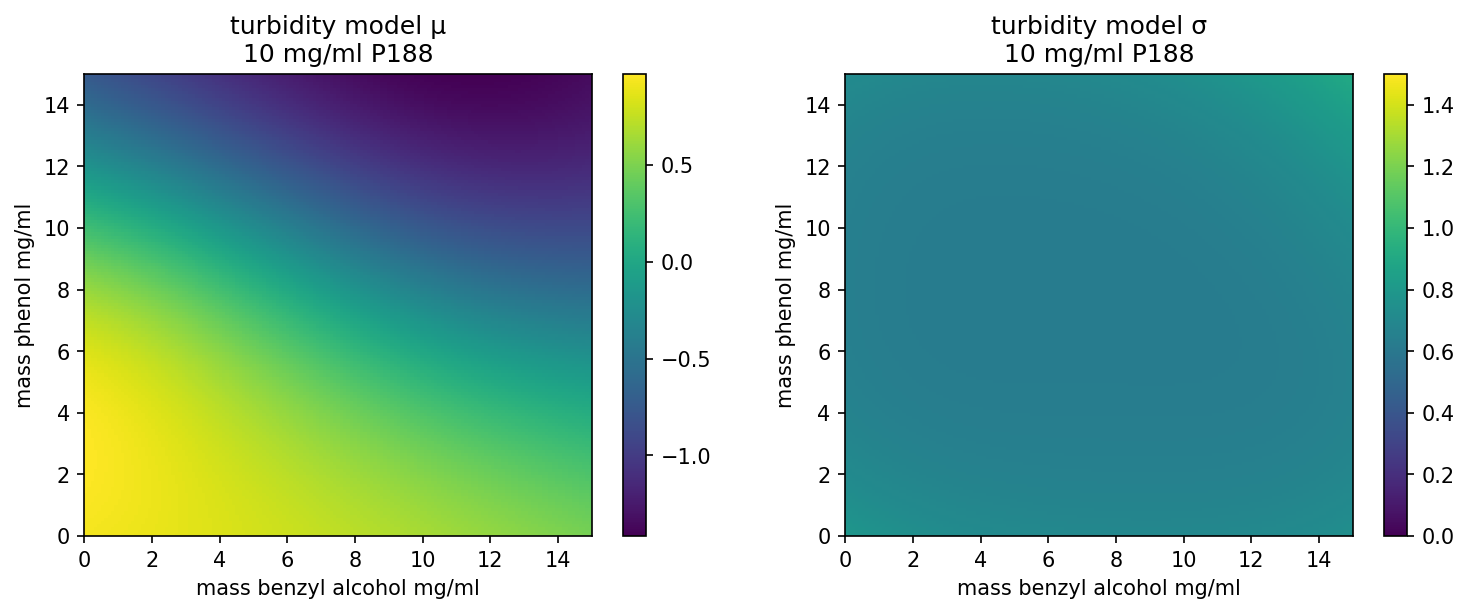

In [16]:
#standard GP with an RBF kernel
# model = gpflow.models.GPR(
#     (X1, y1),
#     kernel=gpflow.kernels.SquaredExponential(),
# )
kernel = gpflow.kernels.Matern52(variance=0.5,lengthscales=2.0) + gpflow.kernels.White(1e-1)
model = gpflow.models.GPR(
    data=(X1, y1),
    kernel=kernel,
)
# Variational Gaussian Process with a studentT liklihood

# model = gpflow.models.VGP(
#     (X1, y1),
#     kernel=gpflow.kernels.SquaredExponential(),
#     # likelihood=gpflow.likelihoods.StudentT(),
#     likelihood=gpflow.likelihoods.Gaussian(),
# )
opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables)

# in normalized GP space where μ = 0.0 and a value of 1.0 is one std dev
mass_ba = np.linspace(X1.min(0)[0],X1.max(0)[0],151)
mass_ph = np.linspace(X1.min(0)[1],X1.max(0)[1],151)

mba, mph = np.meshgrid(mass_ba,mass_ph)
X_eval = np.stack((mba.ravel(), mph.ravel()),axis=1)

μ_posterior, σ_posterior = model.predict_y(X_eval)

fig,ax = plt.subplots(1,2,dpi=150,figsize=(12,4))
imsh1 = ax[0].imshow(μ_posterior.reshape(151,151),origin='lower', extent=[0, 15, 0, 15], aspect='auto')
imsh2 = ax[1].imshow(σ_posterior.reshape(151,151),origin='lower', extent=[0, 15, 0, 15], aspect='auto',vmin=0,vmax=1.5)
ax[0].set(
    xlabel='mass benzyl alcohol mg/ml',
    ylabel='mass phenol mg/ml',
    title ='turbidity model μ\n10 mg/ml P188',
)
plt.colorbar(imsh1,ax=ax[0])
ax[1].set(
    xlabel='mass benzyl alcohol mg/ml',
    ylabel='mass phenol mg/ml',
    title ='turbidity model σ\n10 mg/ml P188',
)
plt.colorbar(imsh2,ax=ax[1])
fig.savefig("HomoskedasticGPR_MaternAndWhite.png")

## Heteroskedastic GPFlow

In [11]:
class HeteroskedasticGaussian(gpflow.likelihoods.Likelihood):
    def __init__(self, **kwargs):
        # this likelihood expects a single latent function F, and two columns in the data matrix Y:
        super().__init__(latent_dim=1, observation_dim=2, **kwargs)

    def _log_prob(self, F, Y):
        # log_prob is used by the quadrature fallback of variational_expectations and predict_log_density.
        # Because variational_expectations is implemented analytically below, this is not actually needed,
        # but is included for pedagogical purposes.
        # Note that currently relying on the quadrature would fail due to https://github.com/GPflow/GPflow/issues/966
        Y, NoiseVar = Y[:, 0], Y[:, 1]
        return gpflow.logdensities.gaussian(Y, F, NoiseVar)

    def _variational_expectations(self, Fmu, Fvar, Y):
        Y, NoiseVar = Y[:, 0], Y[:, 1]
        Fmu, Fvar = Fmu[:, 0], Fvar[:, 0]
        return (
            -0.5 * np.log(2 * np.pi)
            - 0.5 * tf.math.log(NoiseVar)
            - 0.5 * (tf.math.square(Y - Fmu) + Fvar) / NoiseVar
        )

    # The following two methods are abstract in the base class.
    # They need to be implemented even if not used.

    def _predict_log_density(self, Fmu, Fvar, Y):
        raise NotImplementedError

    def _predict_mean_and_var(self, Fmu, Fvar):
        raise NotImplementedError

In [32]:
# model construction
X = X1


y = np.expand_dims(ds_merged['mean_of_maxima'],axis=1).copy()
ϵ = np.expand_dims(ds_merged['std_of_maxima'],axis=1).copy()

y1 = (y - y.mean())/y.std()
σ = ϵ/ϵ.std()

# Y_data = np.stack((y,ϵ))[:,:,0].T
Y_data = np.stack((y1,σ))[:,:,0].T
# Y_data = y1

likelihood = HeteroskedasticGaussian()
# likelihood = gpflow.likelihoods.Gaussian()
kernel = gpflow.kernels.Matern52(lengthscales=2.0,variance=0.5) + gpflow.kernels.White(1e-1)
model_test = gpflow.models.VGP((X0, Y_data), kernel=kernel, likelihood=likelihood, num_latent_gps=1)

natgrad = NaturalGradient(gamma=0.5)
# natgrad = tf.optimizers.Nadam()
adam = tf.optimizers.Adam()

set_trainable(model_test.q_mu, False)
set_trainable(model_test.q_sqrt, False)

# for idx in range(ci_niter(1000)):
for idx in range(ci_niter(15)):
    # natgrad.minimize(model_test.training_loss, [(model_test.q_mu, model_test.q_sqrt)])
    adam.minimize(model_test.training_loss, [model_test.q_mu,model_test.q_sqrt])
    adam.minimize(model_test.training_loss, model_test.trainable_variables)

#     if idx in np.linspace(0,1000,11):
#         # in normalized GP space where μ = 0.0 and a value of 1.0 is one std dev
#         mass_ba = np.linspace(X1.min(0)[0],X1.max(0)[0],151)
#         mass_ph = np.linspace(X1.min(0)[1],X1.max(0)[1],151)

#         mba, mph = np.meshgrid(mass_ba,mass_ph)
#         X_eval = np.stack((mba.ravel(), mph.ravel()),axis=1)

#         μ_posterior, σ_posterior = model.predict_f(X_eval)

#         fig,ax = plt.subplots(1,2,dpi=150,figsize=(12,4))
#         imsh1 = ax[0].imshow(μ_posterior.reshape(151,151),origin='lower', extent=[0, 15, 0, 15], aspect='auto')
#         imsh2 = ax[1].imshow(σ_posterior.reshape(151,151),origin='lower', extent=[0, 15, 0, 15], aspect='auto')
#         ax[0].set(
#             xlabel='mass benzyl alcohol mg/ml',
#             ylabel='mass phenol mg/ml',
#             title ='turbidity model μ\n10 mg/ml P188',
#         )
#         plt.colorbar(imsh1,ax=ax[0])
#         ax[1].set(
#             xlabel='mass benzyl alcohol mg/ml',
#             ylabel='mass phenol mg/ml',
#             title ='turbidity model σ\n10 mg/ml P188',
#         )
#         plt.colorbar(imsh2,ax=ax[1])
#         plt.show()
#         plt.close()

    # fig.savefig("GPFlow Heteroskedastic noise input.svg",dpi=300)
model_test

ValueError: Type Parameter is not supported as a gradient source or gradient target.

In [130]:
kernel = gpflow.kernels.Matern52(variance=0.5,lengthscales=2.0) + gpflow.kernels.White(1e-1)
# GP = GaussianProcess.GP(
#     dataset = ds_merged_1,
#     kernel=kernel,
# )
# print(GPR.construct_data(True),(X1,Y_data))
GPR = HscedGaussianProcess.GPR(
    dataset = ds_merged,
    kernel=kernel
)
GPR.optimize(15,progress_bar=True)

GPR.model

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 28.95it/s]


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.5053590806373682
VGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,2.011908005930931
VGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.10140249148002882
VGP.num_data,Parameter,Identity,,False,(),int32,65
VGP.q_mu,Parameter,Identity,,False,"(65, 1)",float64,[[-0.78729734...
VGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 65, 65)",float64,"[[[5.99848486e-01, 0.00000000e+00, 0.00000000e+00..."


### trainied Heteroskedastic GPFlow

## Clustering for analysis

At a bare minimum, we should be able to determine the boundary of a completely turbid solution and use that to mask the neutron scattering GP regression model

In [70]:
### Imports for Similarity Metrics
from AFL.agent import xarray_extensions
from AFL.agent import reduce_usaxs

from AFL.agent.AgentClient import AgentClient
from AFL.agent import Metric,PhaseLabeler,AcquisitionFunction,GaussianProcess,HscedGaussianProcess

from scipy.spatial.distance import pdist


In [120]:
ds_merged

<xarray.Dataset>
Dimensions:                   (time: 98, wavelength: 2047, sample: 62,
                               solutes: 3, grid: 22801, sample_i: 62,
                               sample_j: 62)
Coordinates:
  * time                      (time) float64 0.0 0.102 0.1021 ... 4.898 4.9 5.0
  * wavelength                (wavelength) float64 181.2 181.5 ... 867.7 867.9
  * solutes                   (solutes) object 'mass_P188' ... 'mass_phenol'
Dimensions without coordinates: sample, grid, sample_i, sample_j
Data variables: (12/20)
    raw                       (sample, time, wavelength) float64 110.0 ... 121.0
    filtered_data_iqr         (sample, time, wavelength) float64 110.0 ... 121.0
    mean_of_maxima            (sample) float64 3.139e+03 165.2 ... 1.25e+03
    std_of_maxima             (sample) float64 264.3 3.59 188.8 ... 208.5 271.5
    filtered_data_1std        (sample, time, wavelength) float64 110.0 ... 121.0
    maxima                    (sample, time) float64 3.241e+03 nan ... 1.188e+03
    ...                        ...
    GP_var                    (grid) float64 0.5278 0.5235 ... 0.566 0.5676
    mass_benzyl_alcohol_grid  (grid) float64 0.0 0.0 0.0 0.0 ... 15.0 15.0 15.0
    mass_phenol_grid          (grid) float64 0.0 0.1 0.2 0.3 ... 14.8 14.9 15.0
    t_avg_scan                (sample, wavelength) float64 108.6 109.1 ... 124.0
    W                         (sample_i, sample_j) float64 1.0 0.7205 ... 1.0
    labels                    (sample) int64 0 1 0 0 0 0 1 0 ... 0 0 0 0 1 0 0 0
Attributes:
    components:                      ['mass_benzyl_alcohol', 'mass_phenol']
    AL_data:                         mean_of_maxima
    input_uncert:                    std_of_maxima
    mass_benzyl_alcohol_range:       (0, 15)
    mass_phenol_range:               (0, 15)
    components_grid:                 ['mass_benzyl_alcohol_grid', 'mass_pheno...
    mass_benzyl_alcohol_grid_range:  (0, 15)
    mass_phenol_grid_range:          (0, 15)
    metric:                          {'metric_0': {'name': 't_avg_scan', 'dat...
    n_phases:                        2

Found 2 phases!


[Text(0.5, 1.0, 'composite dataset')]

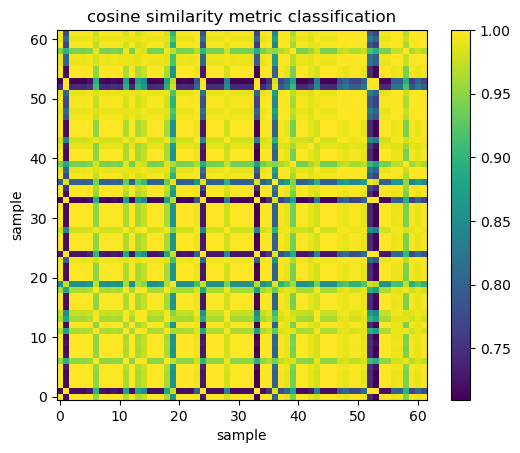

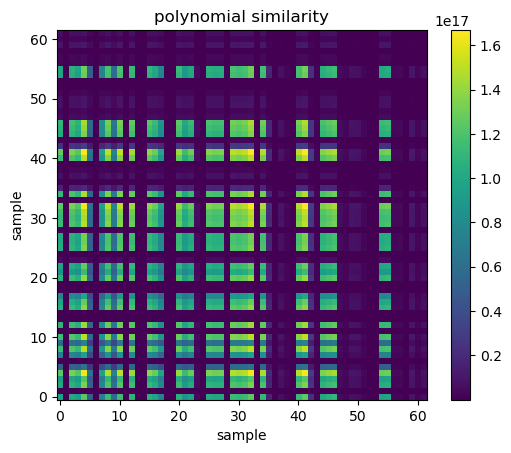

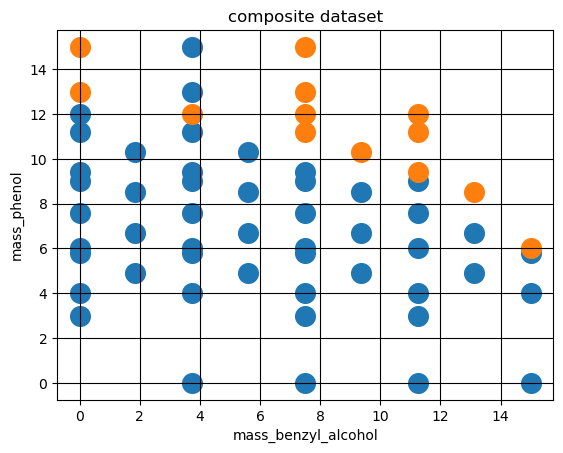

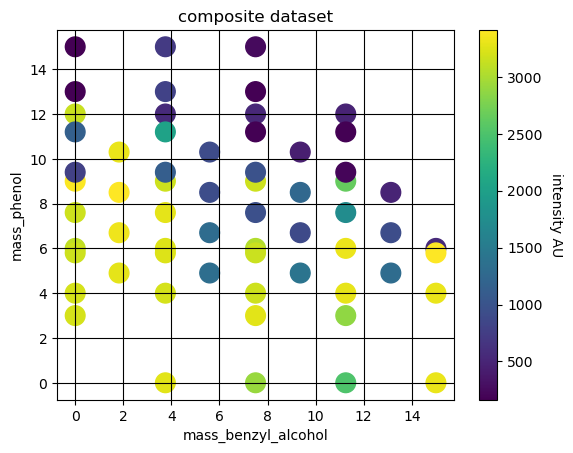

In [119]:
# ds_master = ds_master.rename_dims(measurement='sample')
ds_merged['t_avg_scan'] = ds_merged['raw'].mean(dim='time')
metric1 = Metric.Similarity('t_avg_scan',  name='t_avg_scan',  params=dict(metric='cosine'))

# metric2 = Metric.Similarity('deriv1',name='',params=dict(metric='poly',gamma=1e-4,power=0.5))
metric2 = Metric.Similarity('t_avg_scan',  name='t_avg_scan',  params=dict(metric='poly',gamma=1e-4,power=0.5))
metric1.calculate(ds_merged)
metric2.calculate(ds_merged)
# metric2 = Metric.Similarity('deriv1',name='deriv1',params=dict(metric='poly',gamma=1e-4,power=0.5))

metric = Metric.MultiMetric(
    [metric1,metric2],
    combine_by='sum',
    combine_by_powers=[1,1],
    combine_by_coeffs=[1,0],
    constrain_same=None,
    constrain_different=None,
)
metric.calculate(ds_merged)

fig,axes = plt.subplots(1,1)
mmap = axes.imshow(metric1.W,origin='lower')
plt.colorbar(mappable=mmap,ax=axes)
axes.set(
    xlabel = "sample",
    ylabel = "sample",
    title = "cosine similarity metric classification"
)

fig,axes = plt.subplots(1,1)
mmap = axes.imshow(metric2.W,origin='lower')
plt.colorbar(mappable=mmap,ax=axes)
axes.set(
    xlabel = "sample",
    ylabel = "sample",
    title = "polynomial similarity"
)

ds_merged['W'] = (('sample_i','sample_j'),metric.W)
ds_merged.attrs['metric'] = str(metric.to_dict())
labeler=PhaseLabeler.SpectralClustering()
# labeler = PhaseLabeler.DBSCAN()
labeler.label(ds_merged)
print(f'Found {labeler.n_phases} phases!')
ds_merged.attrs['n_phases'] = labeler.n_phases
ds_merged['labels'] = ('sample',labeler.labels)

sc  = ds_merged.afl.comp.plot_scatter(['mass_benzyl_alcohol','mass_phenol'],labels='labels',discrete_labels=True, s=200);#,norm=norm);

ax = plt.gca()
ax.set(
    title = 'composite dataset'
)

sc  = ds_merged.afl.comp.plot_scatter(['mass_benzyl_alcohol','mass_phenol'],labels='mean_of_maxima',discrete_labels=False, s=200);#,norm=norm);
cbar = plt.colorbar(sc)
cbar.set_label(label='intensity AU',rotation=270,labelpad=15)
ax = plt.gca()
ax.set(
    title = 'composite dataset'
)
# plt.savefig('230411-230417_composite_dataset.png',dpi=300)

In [83]:
ds_merged.attrs['components'] = ['mass_benzyl_alcohol','mass_phenol']
ds_merged.attrs['AL_data'] = 'mean_of_maxima'
ds_merged.attrs['input_uncert'] = 'std_of_maxima'
ds_merged.attrs['mass_benzyl_alcohol_range'] = (0,15)
ds_merged.attrs['mass_phenol_range'] = (0,15)

ds_merged = ds_merged.afl.comp.add_grid(pts_per_row=151,overwrite=True)
# try:
#     ds_merged = ds_merged.afl.comp.add_grid()
# except:
#     pass

--> Making grid for components ['mass_benzyl_alcohol', 'mass_phenol'] at 151 pts_per_row
{'mass_benzyl_alcohol': {'min': 0, 'max': 15, 'steps': 151}, 'mass_phenol': {'min': 0, 'max': 15, 'steps': 151}}


  0%|          | 0/22801 [00:00<?, ?it/s]

In [118]:
kernel = gpflow.kernels.Matern52(variance=0.5,lengthscales=2.0) + gpflow.kernels.White(1e-1)
# GP = GaussianProcess.GP(
#     dataset = ds_merged_1,
#     kernel=kernel,
# )
GPR = HscedGaussianProcess.GPR(
    dataset = ds_merged,
    kernel=kernel
)
# GPR.model
# GPR.optimize(1000,progress_bar=True)

InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input to reshape is a tensor with 62 values, but the requested shape has 22801 [Op:Reshape]

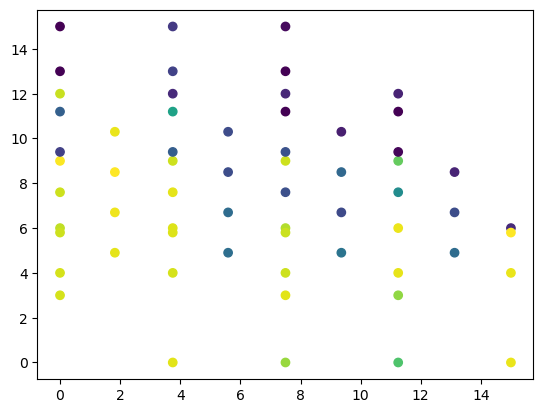

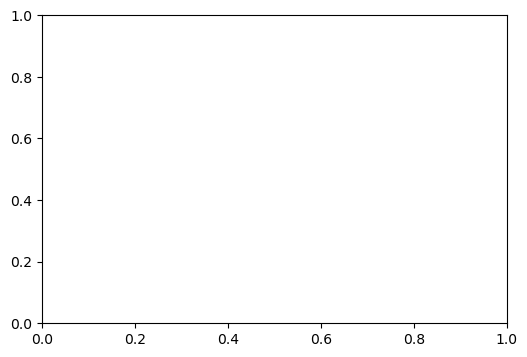

In [121]:
result = GPR.predict(ds_merged.attrs['components_grid'])
# result['mean']
inputs = GPR.construct_data()
plt.scatter(inputs[0][:,0],inputs[0][:,1],c=inputs[1][:,0])
mean,var = GPR.model.predict_f(GPR.transform_domain(components=ds_merged.attrs['components']))

#re-scale the predicted GP to non-standardized values
mean_rs = mean*ds_merged['mean_of_maxima'].std()+ds_merged['mean_of_maxima'].mean()
var_rs = var*ds_merged['std_of_maxima'].std()



fig,ax = plt.subplots(1,1,figsize=(6,4))
m = ax.imshow(mean_rs.reshape(151,151).T/max(mean_rs),aspect='auto',origin='lower',extent=[0,15,0,15])
# ax.scatter(ds_merged['mass_benzyl_alcohol_grid'],ds_merged['mass_phenol_grid'],mean_rs,c=mean_rs)
# plt.colorbar(m)
ax.set(
    title='Turbidity Model Mean',
    xlabel='Benzyl Alcohol Concentration [mg/ml]',
    ylabel='Phenol Concentraion [mg/ml]',
    # xlim = (-1,21),
    # ylim = (-1,31),
    # aspect= 0.6
)
# fig.savefig('Turbidity_GPR_mean_large_space.svg',dpi=300)
# fig.savefig('Turbidity_GPR_mean_large_space.png',dpi=300)
fig.savefig('Turbidity_GPR_mean_sub_space.svg',dpi=300)
fig.savefig('Turbidity_GPR_mean_sub_space.png',dpi=300)

fig,ax = plt.subplots(1,1,figsize=(6,4))
v = ax.imshow(var_rs.reshape(151,151).T/max(var_rs),aspect='auto',origin='lower',extent=[0,15,0,15])
# ax.scatter(ds_merged['mass_benzyl_alcohol_grid'],ds_merged['mass_phenol_grid'],var_rs,c=var_rs)
# plt.colorbar(v)
ax.set(
    title = 'Turbidity Model Variance',
    xlabel='Benzyl Alcohol Concentration [mg/ml]',
    ylabel='Phenol Concentraion [mg/ml]',
    # xlim = (-1,21),
    # ylim = (-1,31),
    # aspect= 0.6
)
# fig.savefig('Turbidity_GPR_variance_large_space.svg',dpi=300)
# fig.savefig('Turbidity_GPR_variance_large_space.png',dpi=300)
fig.savefig('Turbidity_GPR_variance_sub_space.svg',dpi=300)
fig.savefig('Turbidity_GPR_variance_sub_space.png',dpi=300)

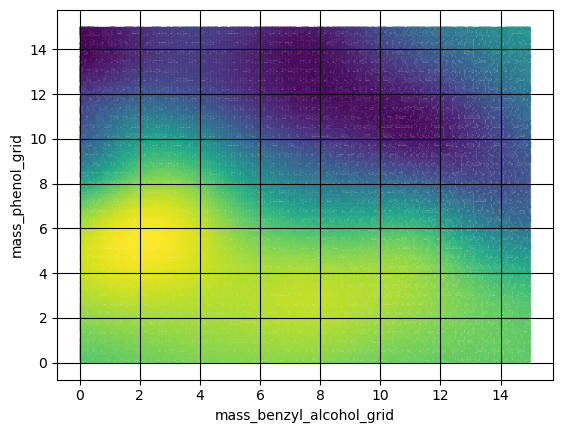

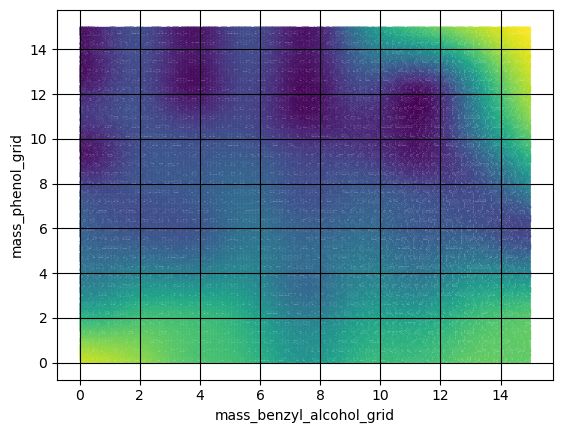

In [86]:
# len(result['mean'])
ds_merged['GP_mean'] = ('grid',result['mean'].squeeze())
ds_merged['GP_var'] = ('grid',result['var'].squeeze())
ds_merged.afl.comp.plot_surface(ds_merged.attrs['components_grid'],labels='GP_mean')
ds_merged.afl.comp.plot_surface(ds_merged.attrs['components_grid'],labels='GP_var')

In [81]:
acq = AcquisitionFunction.IterationCombined(
    function1=AcquisitionFunction.Variance(),
    function2=AcquisitionFunction.LowestDensity(bandwidth=0.035),
    function2_frequency=5
)

acq.reset_phasemap(ds_merged)
ds_AL = acq.calculate_metric(GPR)

composition_check = ds_merged[ds_merged.attrs['components']]
if 'sample' in composition_check.indexes:
    composition_check = composition_check.reset_index('sample').reset_coords(drop=True)
composition_check = composition_check.to_array('component').transpose('sample',...)

next_sample = acq.get_next_sample( composition_check = composition_check )
next_sample

Using acquisition function variance of iteration 1
Creating ordered metric lists...
Running get_next_sample with sample_randomly=False
Running iteration 0
Getting random point within 0.03 of maximum...
Verifying that gridpoint isn't on top of previous measurement...
Found that gridpoint 34 satisfies the acquistion function and all constraints


<xarray.DataArray (component: 2)>
array([14.4, 14.6])
Coordinates:
  * component  (component) object 'mass_benzyl_alcohol' 'mass_phenol'
Attributes: (12/13)
    components:                      ['mass_benzyl_alcohol', 'mass_phenol']
    AL_data:                         mean_of_maxima
    input_uncert:                    std_of_maxima
    mass_benzyl_alcohol_range:       (0, 15)
    mass_phenol_range:               (0, 15)
    components_grid:                 ['mass_benzyl_alcohol_grid', 'mass_pheno...
    ...                              ...
    mass_phenol_grid_range:          (0, 15)
    acq_metric:                      variance-LowestDensity@5
    acq_current_metric:              variance
    acq_metric1:                     variance
    acq_metric2:                     LowestDensity
    acq_iteration:                   1

In [124]:
# def local_outlier_scrub(X,y,cutoff_distance=0., IQR=False, σ=2.):
#     """
#     A function to filter data by spatial distribution
    
#     Parameters
#     ----------
#     X: np.array
#         input array of coordinates to calculate distances over
    
#     y: np.array
#         values at the coordinates in X
        
#     IQR: bool
#         use the IQR to filter
        
#     σ: np.float
#         number of std's to filter the mean by
        
        
#     Returns
#     -------
    
#     X_new: np.array
#         filtered coordinates
#     """
#     for i in X:
        
    
    
#     return X_new, y_new


# def function(x,a,dummy=True):
#     '''
#     Parameters
#     ----------
#     x: np.float
#         x input variable blah
    
#     a: np.int
#         integer offset
    
#     dummy: bool (default=True)
#     '''
#     return x*a

## LoadStopper data

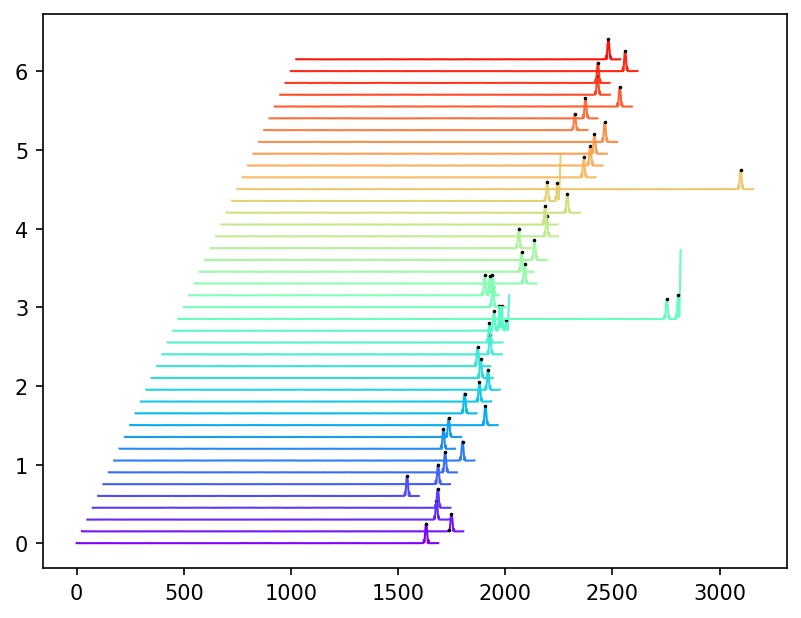

In [79]:
import glob
import os
from scipy.signal import savgol_filter, find_peaks
from skimage.feature import canny
from matplotlib import colors
from matplotlib import cm as cmx


rainbow = plt.get_cmap('rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=rainbow)

ls_data_fnames = list(glob.glob('loadstopper_data/Sensor-230417*.txt'))

fig,ax =plt.subplots(dpi=150)
for idx, file in enumerate(ls_data_fnames):
    # print(os.path.basename(file))
    xy = np.genfromtxt(file,delimiter=' ')
    g_xy = abs(savgol_filter(xy[:,1] - np.mean(xy[:,1]),window_length=25, polyorder=3, deriv=1))
    peaks = find_peaks(g_xy,height=10*np.std(g_xy[:100]),width=(6,25))
    # print(peaks[0],peaks[1]['widths'])
    
    # ax.plot(len(peaks))
    # ax.plot(np.arange(len(xy))+25*idx, xy[:,1] + 4*idx,  alpha= (idx/len(ls_data_fnames))*0.5 + 0.3, c='darkorchid')
    ax.plot(np.arange(len(g_xy))+25*idx, g_xy + 0.15*idx, c=scalarMap.to_rgba(idx/len(ls_data_fnames)),linewidth=1)
    ax.scatter(peaks[0] + 25*idx, g_xy[peaks[0]] + 0.15*idx,c='k', marker='o',s=0.5,zorder=2)
    